Super Smash Brothers Melee (SSBM) is a fighting game released by Nintendo for the Nintendo Gamecube in 2001. Despite its age, SSBM has maintained an active competitive scene throughout most of its lifetime, with recent years seeing some of the highest attendance numbers for tournaments in its competitive history (this can be attributed to a multitude of factors, such as the release of "The Smash Brothers" Documentary and the game's inclusion into the EVO tournament series, the largest annual fighting game tournament in the world). Competitive SSBM tournaments are double elimination brackets with the majority of "sets" being best of three or best of five. Each game in a set consists of two players (who each can pick a character from a roster of 26 possible characteres) each with four lives ("stocks"), who can pick a stage to play on from a specific set of possibles stages. The use of items and other game-influencing mechanics is prohibited throughout the tournament. Unlike most other 2D fighters that feature a health bar that decreases as the player takes damage from attacks, players reaching their demise when the bar reaches zero, SSBM functions completely opposite: Whether a player crosses the borders of the stage (blast zone) determines the death of the player and players are given a percent counter that increases until reaching a hard cap of 999% making them increasingly more likely to hit the blast zone.

Until recently, the majority of statistics related to competitive SSBM have been "high-level", i.e they hasve mostly involved studying head-to-head matchups of players, winrates of specific players, and winrates of specific characters. While there is much that can be learned from studying these statistics, there is a lack of analysis of in-game statistics. This is analogous to a lack of statistics such as RBI and Batting Average for competitive Baseball analysis. While winning is important, this is very much a "black box" and does little in the way of explanation.

Recent technology - specifically the SmashSight project, which utilizes neural networks to analyze footage of competitive SSBM gameplay in a frame-by-frame manner - allows for the aforementioned in-game analysis. SmashSight specifically takes in footage of competitive SSBM gameplay and returns a comma seperated table containing frame-by-frame radsings of each player's stock count and "percentage" points (which is a rough measure of their health - the higher a player's percentage, the further they are launched by getting hit). 

In this project we utilize SmashSight's publicly available data of the majority of the top eight sets from the Genesis 5 tournament. A main topic we explore is how winrate is affected via intermediate statistics that we gather from the data such as: Average percent dealt/received per frame, percent survived to per stock, and kill percentages.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
#These are helper functions to make the data collection process easier
def standardize_name(char):
    if 'Fox' in char:
        return 'Fox'
    elif 'Sheik' in char:
        return 'Shiek'
    elif 'JigglyPuff' in char:
        return 'JigglyPuff'
    elif 'Peach' in char:
        return 'Peach'
    elif 'Falco' in char:
        return 'Falco'
    elif 'Pikachu' in char:
        return 'Pikachu'
    elif 'Samus' in char:
        return 'Samus'
    else: #should never be reached with this dataset
        return ''

def get_set_winner(list_of_game_data):
    return ''
    #TODO: returns winner of a set, as given by the list of dfs
    
#Reads in a url for the SmashSight data and parses it
#Returns a dictionary containing the player names, the player chars, the stage, the winner, and a dataframe containing the
#frame-by-frame data for the game
def read_fbf_data(url):
    data = requests.get(url).text.split('\n')
    del data[0]
    del data[1]
    rows = []
    cols = ['frame', 'L_Player_dmg', 'R_Player_dmg', 'L_Player_stocks', 'R_Player_stocks']
    meta_data = data[0].split(',')
    meta_data = [e for e in meta_data if e != 'NA']
    ret = {}
    L_Player_name = meta_data[1]
    R_Player_name = meta_data[2]
    L_Player_char = standardize_name(meta_data[3])
    R_Player_char = standardize_name(meta_data[4])
    Stage = meta_data[5]
    Winner = ''
    if meta_data[3] in meta_data[6] :
        Winner = L_Player_name
    else:
        Winner = R_Player_name
    ret['L_Player_Name'] = L_Player_name
    ret['R_Player_Name'] = R_Player_name
    ret['L_Player_Char'] = L_Player_char
    ret['R_Player_Char'] = R_Player_char
    ret['Stage'] = Stage
    ret['Winner'] = Winner
    
    for i in range(1, len(data)):
        row = []
        frame_data = data[i].split(',')
        frame_data = [e for e in frame_data if e !='NA']
        frame = frame_data[0]
        L_Player_dmg = frame_data[1]
        R_Player_dmg = frame_data[2]
        L_Player_stocks = frame_data[3]
        R_Player_stocks = frame_data[4]
        row = [frame, L_Player_dmg, R_Player_dmg, L_Player_stocks, R_Player_stocks]
        rows.append(row)
        if url == 'https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_4.txt' and frame == '4627':
            break
    df_ret = pd.DataFrame(data=rows, columns = cols)
    ret['game_data'] = df_ret
    return ret

def convert_to_int(arr):
    ret = []
    for ele in arr:
        ret.append(int(ele))
        
    return ret

#returns the frames on which a given player died 
#i.e if at frame 461 the player has 4 stocks and at frame 462 the player has 3 stocks,
#the number 462 will be returned (possibly among others)
def detect_death(frames, stock_count):
    ret = []
    for fr in range(1, len(frames)):
        if(stock_count[fr] < stock_count[fr - 1]):
            ret.append(fr)
    return ret

#returns the death percentages for a given player for a given game
def find_death_pct(frames, pcts, stocks):
    ret = []
    death_frames = detect_death(frames, stocks)
    for fr in death_frames:
        ret.append(pcts[fr - 1])
    return ret
    
#computes the average death percentages for a given player on a given game
def compute_avg_death_pct(frames, pcts, stocks):
    avg = 0
    death_pcts = find_death_pct(frames, pcts, stocks)
    for pct in death_pcts:
        avg = avg + pct
    
    if(len(death_pcts) != 4):
        avg = avg/(len(death_pcts) + 1)
    else:
        avg = avg/(len(death_pcts))
        
    return avg
       
#computes the average dmg taken by a player over a given frame range
def compute_avg_dmg_taken(frame, pcts, start, end):
    avg = 0
    #frames of invulnerability
    angel_frames = 0
    for fr in range(start, end - 1):
        if(pcts[fr] == -1):
            angel_frames = angel_frames + 1
            continue
        #damage differential per frame
        #will always be nonnegative
        diff = pcts[fr + 1] - pcts[fr]
        avg = avg + diff
    #average over the number of frames in the range
    avg = avg/(end - start - angel_frames)
    return avg

def compute_avg_dmg_taken_per_stock(frames, pcts, stocks):
    death_frames = detect_death(frames, stocks)
    avg = 0
    
    #used to make the computations correct
    death_frames.insert(0, 0)
    if len(death_frames) != 4:
        death_frames.append(frames[len(frames) - 1])
        
    for i in range(1, len(death_frames) - 1):
        if i == 0:
            avg = avg + compute_avg_dmg_taken(frames, pcts, 0, death_frames[i])
        else:
            avg = avg + compute_avg_dmg_taken(frames, pcts, death_frames[i - 1], death_frames[i])
        i = i + 1
    avg = avg/(len(death_frames))
    return avg
    
#computes the stock efficiency of the subject player, defined as avg_death_pct/avg_kill_pct
def compute_stock_score(frames, tar_pcts, tar_stocks, sub_pcts, sub_stocks):
    avg_kill_pct = compute_avg_death_pct(frames, tar_pcts, tar_stocks)
    avg_death_pct = compute_avg_death_pct(frames, sub_pcts, sub_stocks)
    return (avg_death_pct/avg_kill_pct)

def compute_dmg_score(frames, tar_pcts, tar_stocks, sub_pcts, sub_stocks):
    avg_dmg_dealt = compute_avg_dmg_taken_per_stock(frames, tar_pcts, tar_stocks)
    avg_dmg_taken = compute_avg_dmg_taken_per_stock(frames, sub_pcts, sub_stocks)
    return (avg_dmg_dealt/avg_dmg_taken)
    
    
def killpct_R(row):
    if row['detect_death_L'] == 1:
        return int(row['L_Player_dmg'])
    else:
        return 0
    
def deathpct_L(row):
    if row['detect_death_L'] == 1:
        return int(row['L_Player_dmg'])
    else:
        return 0
    
def killpct_L(row):
    if row['detect_death_R'] == 1:
        return int(row['R_Player_dmg'])
    else:
        return 0
    
def stockeff(row):
    if row['avg_kill_pct'] == 0:
        return row['avg_death_pct']/300
    else:
        return row['avg_death_pct']/row['avg_kill_pct']

def win_L(row):
    if row['L_Player_Name'] == row['Winner']:
        return True
    else:
        return False

def win_R(row):
    if row['R_Player_Name'] == row['Winner']:
        return True
    else:
        return False

In [3]:
# Gathering data from SmashSight CSVs, collecting the resultant dataframes into a single dictionary 
#(one dataframe per game)
game_fbf_data = {}
player_data = {}
game_fbf_data['genesis 5_armada VS leffen_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-leffen_1.txt')
game_fbf_data['genesis 5_armada VS leffen_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-leffen_2.txt')
game_fbf_data['genesis 5_armada VS leffen_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-leffen_3.txt')
game_fbf_data['genesis 5_armada VS leffen_4'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-leffen_4.txt')
game_fbf_data['genesis 5_armada VS plup_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-plup_1.txt')
game_fbf_data['genesis 5_armada VS plup_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-plup_2.txt')
game_fbf_data['genesis 5_armada VS plup_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-plup_3.txt')
game_fbf_data['genesis 5_leffen VS hbox_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_leffen-VS-hbox_1.txt')
game_fbf_data['genesis 5_leffen VS hbox_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_leffen-VS-hbox_2.txt')
game_fbf_data['genesis 5_leffen VS hbox_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_leffen-VS-hbox_3.txt')
game_fbf_data['genesis 5_leffen VS hbox_4'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_leffen-VS-hbox_4.txt')
game_fbf_data['genesis 5_leffen VS hbox_5'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_leffen-VS-hbox_5.txt')
game_fbf_data['genesis 5_armada VS lucky_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-lucky_1.txt')
game_fbf_data['genesis 5_armada VS lucky_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-lucky_2.txt')
game_fbf_data['genesis 5_armada VS lucky_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_armada-VS-lucky_3.txt')
game_fbf_data['genesis 5_hugs VS lucky_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hugs-VS-lucky_1.txt')
game_fbf_data['genesis 5_hugs VS lucky_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hugs-VS-lucky_2.txt')
game_fbf_data['genesis 5_hugs VS lucky_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hugs-VS-lucky_3.txt')
game_fbf_data['genesis 5_axe VS mango_1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_1.txt')
game_fbf_data['genesis 5_axe VS mango_2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_2.txt')
game_fbf_data['genesis 5_axe VS mango_3'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_3.txt')
game_fbf_data['genesis 5_axe VS mango_4'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_4.txt')
game_fbf_data['genesis 5_axe VS mango_5'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_axe-VS-mango_5.txt')
game_fbf_data['genesis 5_plup VS hbox_1_WF'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_plup-VS-hbox_1_WF.txt')
game_fbf_data['genesis 5_plup VS hbox_2_WF'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_plup-VS-hbox_2_WF.txt')
game_fbf_data['genesis 5_plup VS hbox_3_WF'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_plup-VS-hbox_3_WF.txt')
game_fbf_data['genesis 5_plup VS hbox_4_WF'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_plup-VS-hbox_4_WF.txt')
game_fbf_data['genesis 5_hbox VS plup_1_GF1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_1_GF1.txt')
game_fbf_data['genesis 5_hbox VS plup_2_GF1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_2_GF1.txt')
game_fbf_data['genesis 5_hbox VS plup_3_GF1'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_3_GF1.txt')
game_fbf_data['genesis 5_hbox VS plup_1_GF2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_1_GF2.txt')
game_fbf_data['genesis 5_hbox VS plup_2_GF2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_2_GF2.txt')
game_fbf_data['genesis 5_hbox VS plup_3_GF2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_3_GF2.txt')
game_fbf_data['genesis 5_hbox VS plup_4_GF2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_4_GF2.txt')
game_fbf_data['genesis 5_hbox VS plup_5_GF2'] = read_fbf_data('https://smashsight.com/wp-content/uploads/2018/11/genesis-5_hbox-VS-plup_5_GF2.txt')

In [4]:

for k in game_fbf_data:
    player_data[game_fbf_data[k]['L_Player_Name']] = {}
    player_data[game_fbf_data[k]['R_Player_Name']] = {}

cols = ['Versus', 'Avg_Death_Pct', 'Avg_Kill_Pct', 'Avg_Dmg_Dealt_Per_Frame', 'Avg_Dmg_Taken_Per_Frame', 'Stock_Score', 'Dmg_Score', 'Player_Char', 'Versus_Char', 'Stage', 'Won']
for player in player_data:
    rows = []
    for game in game_fbf_data:
        if player == game_fbf_data[game]['L_Player_Name']:
            frames = convert_to_int(game_fbf_data[game]['game_data']['frame'])
            r_player_pcts = convert_to_int(game_fbf_data[game]['game_data']['R_Player_dmg'])
            r_player_stocks = convert_to_int(game_fbf_data[game]['game_data']['R_Player_stocks'])
            l_player_pcts = convert_to_int(game_fbf_data[game]['game_data']['L_Player_dmg'])
            l_player_stocks = convert_to_int(game_fbf_data[game]['game_data']['L_Player_stocks'])
            l_player_char = game_fbf_data[game]['L_Player_Char']
            r_player_char = game_fbf_data[game]['R_Player_Char']
            
            Won = (player == game_fbf_data[game]['Winner'])
            Versus = game_fbf_data[game]['R_Player_Name']
            Avg_Death_Pct = compute_avg_death_pct(frames, l_player_pcts, l_player_stocks)
            Avg_Kill_Pct = compute_avg_death_pct(frames, r_player_pcts, r_player_stocks)
            Stage = game_fbf_data[game]['Stage']
            Avg_Dmg_Dealt_Per_Frame = compute_avg_dmg_taken_per_stock(frames, r_player_pcts, r_player_stocks)
            Avg_Dmg_Taken_Per_Frame = compute_avg_dmg_taken_per_stock(frames, l_player_pcts, l_player_stocks)
            Stock_Score = compute_stock_score(frames, r_player_pcts, r_player_stocks, l_player_stocks, l_player_stocks)
            Dmg_Score = compute_dmg_score(frames, r_player_pcts, r_player_stocks, l_player_pcts, l_player_stocks)
            rows.append([Versus, Avg_Death_Pct, Avg_Kill_Pct, Avg_Dmg_Dealt_Per_Frame, Avg_Dmg_Taken_Per_Frame, Stock_Score, Dmg_Score, l_player_char, r_player_char, Stage, Won])
            
        elif player == game_fbf_data[game]['R_Player_Name']:
            frames = convert_to_int(game_fbf_data[game]['game_data']['frame'])
            r_player_pcts = convert_to_int(game_fbf_data[game]['game_data']['R_Player_dmg'])
            r_player_stocks = convert_to_int(game_fbf_data[game]['game_data']['R_Player_stocks'])
            l_player_pcts = convert_to_int(game_fbf_data[game]['game_data']['L_Player_dmg'])
            l_player_stocks = convert_to_int(game_fbf_data[game]['game_data']['L_Player_stocks'])
            l_player_char = game_fbf_data[game]['L_Player_Char']
            r_player_char = game_fbf_data[game]['R_Player_Char']
            
            Won = (player == game_fbf_data[game]['Winner'])
            Versus = game_fbf_data[game]['L_Player_Name']
            Avg_Death_Pct = compute_avg_death_pct(frames, r_player_pcts, r_player_stocks)
            Avg_Kill_Pct = compute_avg_death_pct(frames, l_player_pcts, l_player_stocks)
            Stage = game_fbf_data[game]['Stage']
            Avg_Dmg_Dealt_Per_Frame = compute_avg_dmg_taken_per_stock(frames, l_player_pcts, l_player_stocks)
            Avg_Dmg_Taken_Per_Grame = compute_avg_dmg_taken_per_stock(frames, r_player_pcts, r_player_stocks)
            Stock_Score = compute_stock_score(frames, l_player_pcts, l_player_stocks, r_player_pcts, r_player_stocks)
            Dmg_Score = compute_dmg_score(frames, l_player_pcts, l_player_stocks, r_player_pcts, r_player_stocks)
            rows.append([Versus, Avg_Death_Pct, Avg_Kill_Pct, Avg_Dmg_Dealt_Per_Frame, Avg_Dmg_Taken_Per_Frame, Stock_Score, Dmg_Score, r_player_char, l_player_char, Stage, Won])
            
        else:
            continue
    df = pd.DataFrame(data=rows, columns=cols)
    player_data[player] = df

char_data = {}
for k in game_fbf_data:
    char_data[game_fbf_data[k]['L_Player_Char']] = {}
    char_data[game_fbf_data[k]['R_Player_Char']] = {}
    
cols = ['Versus', 'Avg_Death_Pct', 'Avg_Kill_Pct', 'Avg_Dmg_Dealt_Per_Frame', 'Avg_Dmg_Taken_Per_Frame', 'Stock_Score', 'Dmg_Score', 'Stage', 'Won']
for char in char_data:
    rows = []
    for player in player_data:
        for i, row in player_data[player].iterrows():
            if char == row[7]:
                rows.append([row[8], row[1], row[2], row[3], row[4], row[5], row[6], row[9], row[10]])
            else:
                continue
    char_table = pd.DataFrame(data = rows, columns = cols)
    char_data[char] = char_table
print(char_data['Fox'])
print(player_data)

        Versus  Avg_Death_Pct  Avg_Kill_Pct  Avg_Dmg_Dealt_Per_Frame  \
0          Fox      23.250000     58.250000                 0.042316   
1          Fox      59.000000     28.666667                 0.030296   
2          Fox      59.750000     29.250000                 0.023349   
3          Fox      39.250000     49.500000                 0.013693   
4        Shiek      55.750000     33.250000                 0.023862   
5        Shiek      68.000000     31.750000                 0.012877   
6        Shiek      77.500000     31.000000                 0.017173   
7          Fox      58.250000     23.250000                 0.013398   
8          Fox      28.666667     59.000000                 0.033287   
9          Fox      29.250000     59.750000                 0.028173   
10         Fox      49.500000     39.250000                 0.039997   
11  JigglyPuff      72.250000     21.500000                 0.008967   
12  JigglyPuff      51.333333     39.500000                 0.03

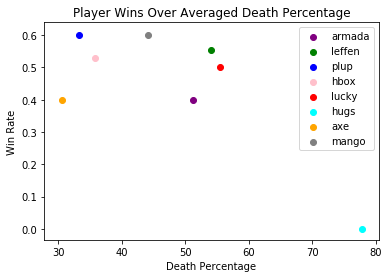

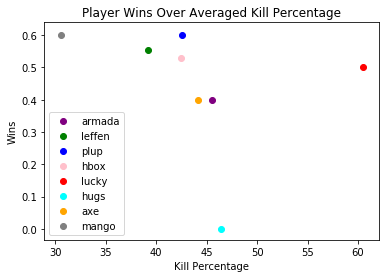

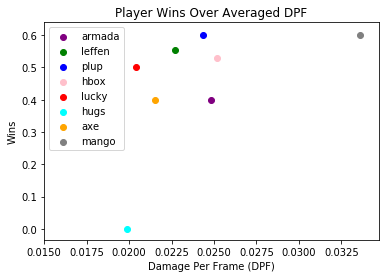

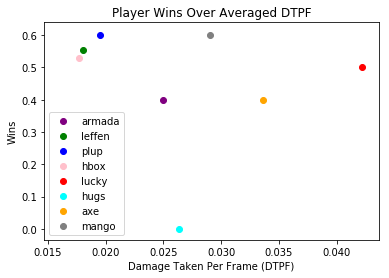

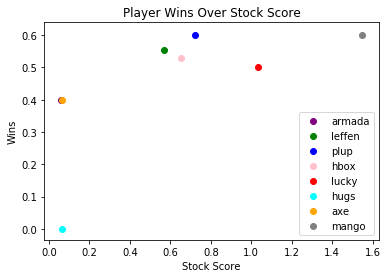

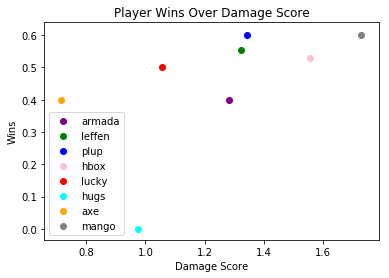

In [8]:
color = ["purple", "green", "blue", "pink", "red", "cyan", "orange", "grey"]

i = 0
fig = plt.figure(1)
DeathPool = pd.DataFrame(columns=['ADP','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Avg_Death_Pct'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Death Percentage')
    plt.ylabel('Win Rate')
    plt.title( 'Player Wins Over Averaged Death Percentage')
    plt.legend()
    DeathPool.loc[i] = [player_data[player]['Avg_Death_Pct'].mean(),player_data[player]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(2)
KillPool = pd.DataFrame(columns=['AKP','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Avg_Kill_Pct'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Kill Percentage')
    plt.ylabel('Wins')
    plt.title( 'Player Wins Over Averaged Kill Percentage')
    plt.legend()
    KillPool.loc[i] = [player_data[player]['Avg_Kill_Pct'].mean(),player_data[player]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(3)
DamagePool = pd.DataFrame(columns=['DPF','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Avg_Dmg_Dealt_Per_Frame'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Damage Per Frame (DPF)')
    plt.ylabel('Wins')
    plt.title( 'Player Wins Over Averaged DPF')
    plt.legend()
    DamagePool.loc[i] = [player_data[player]['Avg_Dmg_Dealt_Per_Frame'].mean(),player_data[player]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(4)
TakenPool = pd.DataFrame(columns=['DTPF','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Avg_Dmg_Taken_Per_Frame'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Damage Taken Per Frame (DTPF)')
    plt.ylabel('Wins')
    plt.title( 'Player Wins Over Averaged DTPF')
    plt.legend()
    TakenPool.loc[i] = [player_data[player]['Avg_Dmg_Taken_Per_Frame'].mean(),player_data[player]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(5)
StockPool = pd.DataFrame(columns=['StS','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Stock_Score'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Stock Score')
    plt.ylabel('Wins')
    plt.title( 'Player Wins Over Stock Score')
    plt.legend()
    StockPool.loc[i] = [player_data[player]['Stock_Score'].mean(),player_data[player]['Won'].mean()]
    i += 1    

i = 0
fig = plt.figure(6)
DamPool = pd.DataFrame(columns=['DS','Win Rate'])
for player in player_data:
    plt.scatter(player_data[player]['Dmg_Score'].mean(),player_data[player]['Won'].mean(),c=color[i],label=player)
    plt.xlabel('Damage Score')
    plt.ylabel('Wins')
    plt.title( 'Player Wins Over Damage Score')
    plt.legend()
    DamPool.loc[i] = [player_data[player]['Dmg_Score'].mean(),player_data[player]['Won'].mean()]
    i += 1    
        
plt.show()

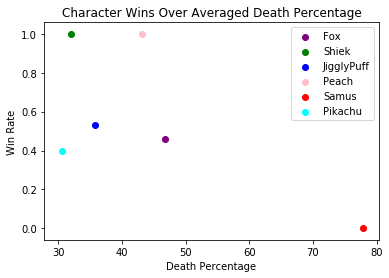

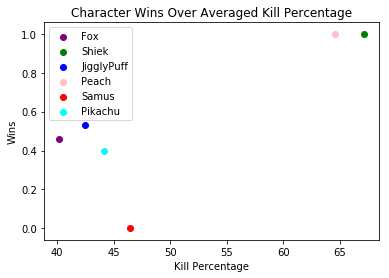

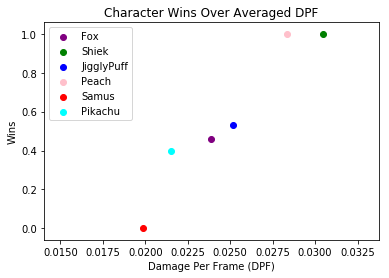

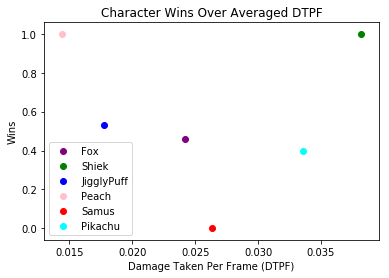

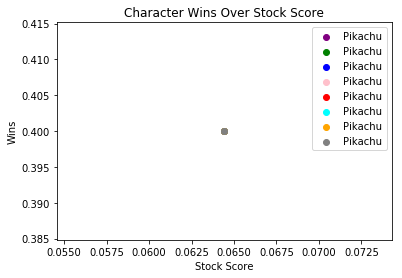

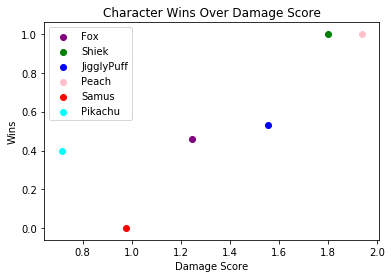

In [17]:
color = ["purple", "green", "blue", "pink", "red", "cyan", "orange", "grey"]

i = 0
fig = plt.figure(1)
DeathPool2 = pd.DataFrame(columns=['ADP','Win Rate'])
for char in char_data:
    plt.scatter(char_data[char]['Avg_Death_Pct'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Death Percentage')
    plt.ylabel('Win Rate')
    plt.title( 'Character Wins Over Averaged Death Percentage')
    plt.legend()
    DeathPool2.loc[i] = [char_data[char]['Avg_Death_Pct'].mean(),char_data[char]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(2)
KillPool2 = pd.DataFrame(columns=['AKP','Win Rate'])
for char in char_data:
    plt.scatter(char_data[char]['Avg_Kill_Pct'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Kill Percentage')
    plt.ylabel('Wins')
    plt.title( 'Character Wins Over Averaged Kill Percentage')
    plt.legend()
    KillPool2.loc[i] = [char_data[char]['Avg_Kill_Pct'].mean(),char_data[char]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(3)
DamagePool2 = pd.DataFrame(columns=['DPF','Win Rate'])
for char in char_data:
    plt.scatter(char_data[char]['Avg_Dmg_Dealt_Per_Frame'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Damage Per Frame (DPF)')
    plt.ylabel('Wins')
    plt.title( 'Character Wins Over Averaged DPF')
    plt.legend()
    DamagePool2.loc[i] = [char_data[char]['Avg_Dmg_Dealt_Per_Frame'].mean(),char_data[char]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(4)
TakenPool2 = pd.DataFrame(columns=['DTPF','Win Rate'])
for char in char_data:
    plt.scatter(char_data[char]['Avg_Dmg_Taken_Per_Frame'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Damage Taken Per Frame (DTPF)')
    plt.ylabel('Wins')
    plt.title( 'Character Wins Over Averaged DTPF')
    plt.legend()
    TakenPool2.loc[i] = [char_data[char]['Avg_Dmg_Taken_Per_Frame'].mean(),char_data[char]['Won'].mean()]
    i += 1

i = 0
fig = plt.figure(5)
StockPool2 = pd.DataFrame(columns=['StS','Win Rate'])
for player in player_data:
    plt.scatter(char_data[char]['Stock_Score'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Stock Score')
    plt.ylabel('Wins')
    plt.title( 'Character Wins Over Stock Score')
    plt.legend()
    StockPool2.loc[i] = [char_data[char]['Stock_Score'].mean(),char_data[char]['Won'].mean()]
    i += 1    

i = 0
fig = plt.figure(6)
DamPool2 = pd.DataFrame(columns=['DS','Win Rate'])
for char in char_data:
    plt.scatter(char_data[char]['Dmg_Score'].mean(),char_data[char]['Won'].mean(),c=color[i],label=char)
    plt.xlabel('Damage Score')
    plt.ylabel('Wins')
    plt.title( 'Character Wins Over Damage Score')
    plt.legend()
    DamPool2.loc[i] = [char_data[char]['Dmg_Score'].mean(),char_data[char]['Won'].mean()]
    i += 1    
plt.show()